In [ ]:
%matplotlib inline  
import pandas as pd #data manipulation
import numpy as np #numerical calculations
import matplotlib.pyplot as plt #plot
import yfinance as yf  #幫我們抓取分析資料
import datetime #時間套件
import ffn #Financial Functions for Python
pd.options.mode.chained_assignment = None  # default='warn' 
#!pip install yfinance 安裝套件指令
#!pip install datetime 安裝套件指令
#!pip install ffn 安裝套件指令

##自由發揮題：制定一個簡單的程式交易策略

* 目的：希望此交易策略能夠跑贏單純'買進持有'(Buy and Hold)策略。

* 交易策略類型：順勢交易-均線交叉策略
* 策略說明：由於移動平均線上升時，價格通常會上升趨勢；移動平均線下降時，價格通常為下跌趨勢。  
故順勢交易策略設計如下：  
買入時機：價格由移動平均線下方突破移動平均線時；當短均線向上交叉長均線。  
賣出時機：價格由移動平均線上方跌破移動平均線時；當短均線向下交叉長均線。  

* 標的：台積電(2330.TW)

* 資料區間：2020/01/01-2022/01/01  
* 資料來源：Yahoo Finance

* 撰寫思路：  
首先，我們先簡單分析標的，讓我們對標的有基本認識。  
再來，制定我們的交易策略，並跑交易回測。  
最後，我們制訂一個策略最佳化函式，取得並套入最佳化參數後，再做交易回測看改善狀況。  
* 策略最佳化的獎勵機制：夏普率  
夏普率= [(每日報酬率平均值- 無風險利率) / (每日報酬的標準差)] x (252平方根)  
ps.本題無風險利率預設1%


In [ ]:
#get data
stock = yf.download('2330.TW',
                start=datetime.datetime(2020, 1, 1),
                end=datetime.datetime(2022, 1, 1))
 

[*********************100%***********************]  1 of 1 completed


###標的基本分析

In [ ]:
#計算日報酬率
daily_return = pd.DataFrame(stock['Adj Close']).apply(lambda x: (x / x.shift(1))-1)
daily_return = daily_return.rename(columns = {'Adj Close':'2330.TW'})

#日報酬率基本統計分析
daily_return.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
2330.TW,487.0,0.00146,0.017015,-0.055555,-0.008418,0.0,0.011379,0.099741


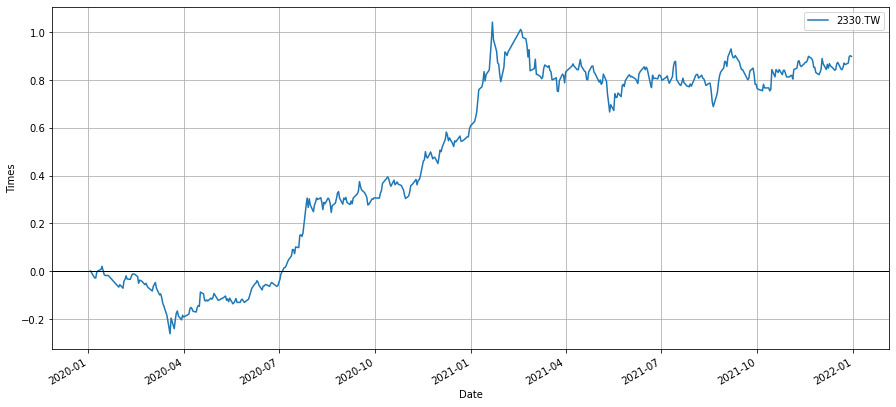

In [ ]:
#標的的累計報酬率圖 #Times 表示成長倍數
cumulative_exret = daily_return.apply(lambda x: (1 + x).cumprod() )
(cumulative_exret-1).plot(figsize=(15,7), grid=True).axhline(y = 0, color = "black", lw = 1)
plt.ylabel("Times")    
plt.show()

In [ ]:
#標的Sharpe Ratio
risk_free=0.01 #無風險利率預設1%
Sharpe_Ratio = np.sqrt(252) * ((daily_return.mean()-risk_free) / daily_return.std())
print(f'標的Sharpe Ratio = {round(float(Sharpe_Ratio),2)}')

標的Sharpe Ratio = -7.97


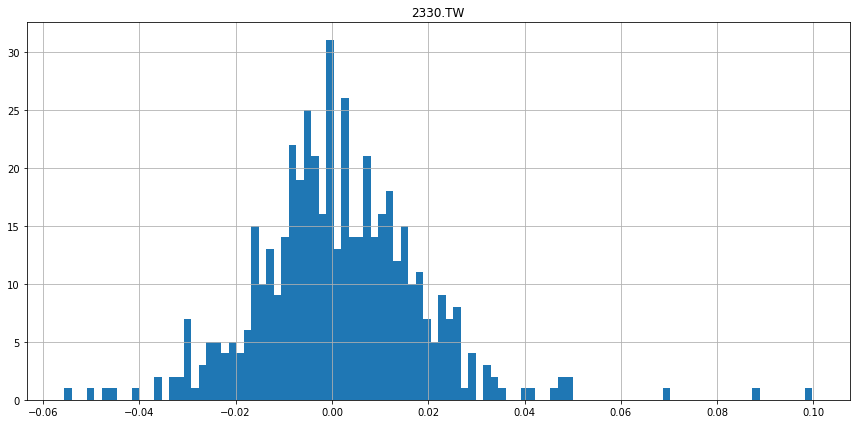

In [ ]:
#了解日報酬率分布狀況
daily_return.hist(bins = 100,figsize = (12, 6)) 
plt.tight_layout()

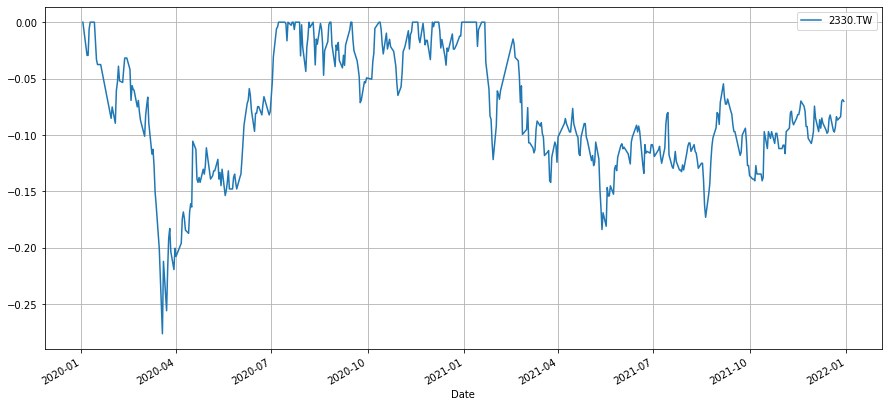

In [ ]:
#了解標的下檔風險、最大回撤
#Calculate the minimum (negative) daily drawdown 
ffn.to_drawdown_series(cumulative_exret).plot(figsize=(15,7),grid=True)
plt.show()

由圖我們可以觀察到2020年1月到7月間最大回撤特別大。

In [ ]:
#制定交易策略 function
#Trade using a simple MA　strategy
def trade(stock, short_window, long_window,picture = True,fee=0.0001,risk_free=0.01): #手續費預設為交易金額的0.01% #無風險利率預設1% #預設開啟繪圖功能
    
    #初始化交易訊號
    signals = pd.DataFrame(index=stock.index) 
    signals['signal'] = 0
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (long_window == 0) or (short_window == 0):
      return 0

    # Compute rolling mean and rolling standard deviation
    #短期均線
    signals['short_mavg'] = np.round(stock['Adj Close'].rolling(window=short_window).mean(), 2)  # np.round 四捨五入到小數後2位
    #長期均線
    signals['long_mavg'] = np.round(stock['Adj Close'].rolling(window=long_window).mean(), 2)

    # 交易策略制定
    # Prerequisite:Start with no money and no positions
    
    #產生交易訊號，訊號產生方式 短均線突破長均線=>Buy=>signal = 1
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1, 0)
    #加上 [short_window:] 是為了遵守條件“僅針對大於最短移動均值視窗的時期”
    
    # Generate trading orders
    signals['positions'] = signals['signal'].diff() #positions = 1 代表現在買入動作

    #每天日報酬率
    signals['D_Ret'] =stock['Adj Close'] / stock['Adj Close'].shift(1)-1   
    #實際持有部位時才計算股票日報酬率
    signals['D_RetMod'] = np.where(signals['signal']==1  , signals['D_Ret'], 0) #持有部位時(signal = 1)的當天日報酬率
    #實際持有股票時+採用策略後的累積報酬率
    signals['D_RetMod-1']= np.where(signals['positions']==1  , signals['D_Ret'], 0) #買入動作(positions = 1)當日報酬率
    #持有部位時(signal = 1)的當天日報酬率，買進日跟賣出日當天positions = 1 OR -1)的報酬率不計算
    signals['D_RetMod-2']= signals['D_RetMod']-signals['D_RetMod-1']

    #考慮手續費，只有買入算一次
    signals['D_RetMod2'] = np.where(signals['positions']==1 ,  signals['D_RetMod-2']-fee, signals['D_RetMod-2'])
    
    #做策略修正，因為交易訊號透過收盤價判斷，賣出部位訊號要修改至隔天，隔天才能將部位賣出
    signals['D_RetMod3'] = np.where(signals['positions']== -1 ,signals['D_Ret'], signals['D_RetMod2']) #隔天才能賣，因此補計算賣出訊號當日(positions=-1)報酬率
 
    # 計算累積報酬率(績效) # .cumprod()累積乘積 
    signals['CumRetM'] = (1 + signals['D_RetMod3']).cumprod()  #此交易策略績效
    signals['HoldingRet'] = (1 + signals['D_Ret']).cumprod() #一開始Buy and Hold 績效


         
    #Isolate the returns of your strategy
    returns0 =signals['D_Ret'].copy()  #Buy and hold
    returns =signals['D_RetMod3'].copy() # strategy
    
 
    x = returns0.std()
    y = returns.std()

    # annualized Sharpe ratio
    #夏普率= [(每日報酬率平均值- 無風險利率) / (每日報酬的標準差)]x (252平方根)
    
    if (x == 0):
        sharpe_ratio0 = 0

    else:
        # .std()計算陣列標準差 standard deviation 的方法。
        sharpe_ratio0 = np.sqrt(252) * ((returns0.mean()-risk_free) / x)
        
    if (y == 0):
        sharpe_ratio = 0

    else:
        sharpe_ratio = np.sqrt(252) * ((returns.mean()-risk_free) / y)  # 使用 np.std 計算標準差。

   # print(sharpe_ratio0) #Buy and hold
   # print(sharpe_ratio) # strategy
   
    #畫圖比較績效
    if(picture == True):
         #exclude a few columns from a DataFrame plot
         df_compare = signals.loc[:,['CumRetM','HoldingRet']]
         (df_compare-1).plot(figsize=(15,7), grid=True,ylabel='Return')
         print(f'Buy and Hold策略的夏普率{round(sharpe_ratio0,2)}')
         print(f'交易策略的夏普率{round(sharpe_ratio,2)}')
        
    return sharpe_ratio

Buy and Hold策略的夏普率-7.97
交易策略的夏普率-11.18


-11.18189029708262

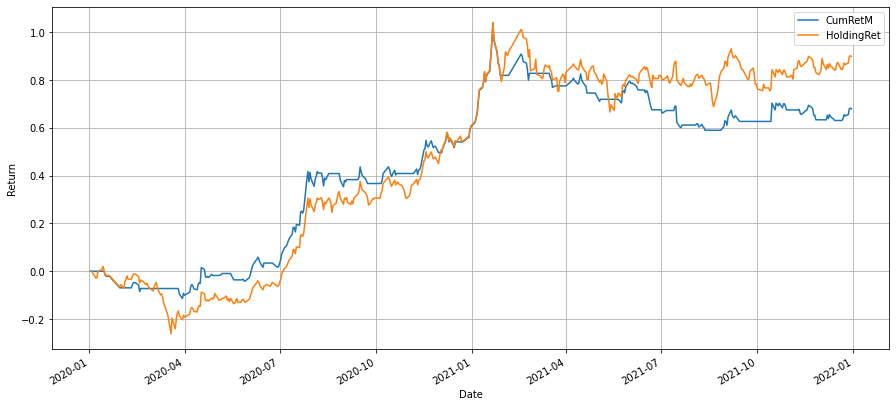

In [ ]:
#先試個 短均線=5日,長均線=10日 看看回測績效
trade(stock, 5, 10)
#CumRetM: 表示交易策略績效
#HoldingRet: 表示買進持有策略績效

In [ ]:
#制定策略最佳化參數 function

def Optimization_1(data, start = 2 , stop= 60, step = 2,start_long = 10, stop_long = 100, step_long = 2):

    i=0
    j=0
    best_i=0
    best_j=0
    #######運算#######
    for i  in range(start, stop, step): # range(start, stop, step) #test short_window
        
        for j in range(start_long, stop_long, step_long): #test long_window
            
            if(j>i):
                            
                sharpe_ratio = trade(data, i, j,picture=False)
                if (i==start)and(j == start_long):
                    results_sharpe = sharpe_ratio
                
               # results_sharpe2[i,j] = sharpe_ratio
                if(sharpe_ratio > results_sharpe):
                    best_i=i
                    best_j=j
                    results_sharpe = sharpe_ratio
                
    op1 = pd.DataFrame(index=data.index)
    op1 = {
        "best_i": best_i,
        "best_j": best_j,
        "results_sharpe": results_sharpe
    }

    return best_i,best_j,round(results_sharpe,2)

In [ ]:
Optimization = Optimization_1(stock)
print(f'最佳化處理後,短均線參數 = {Optimization[0]}日,長均線參數 = {Optimization[1]}日')

最佳化處理後,短均線參數 = 36日,長均線參數 = 76日


Buy and Hold策略的夏普率-7.97
交易策略的夏普率-10.2


-10.202076264428827

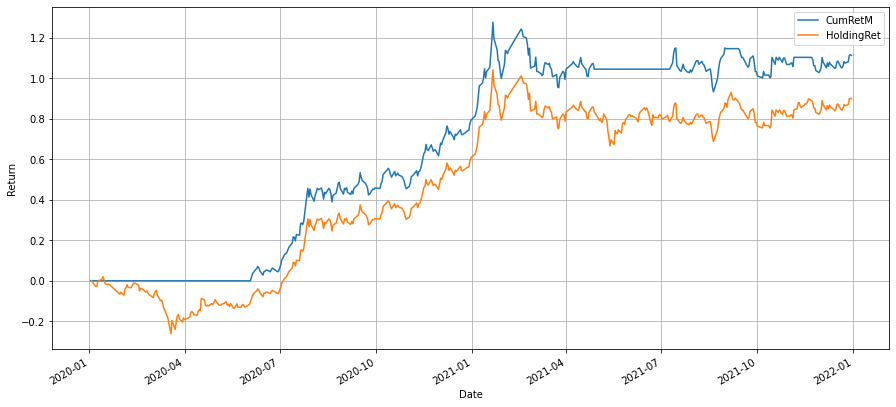

In [ ]:
#跑一下最佳化參數後的績效
trade(stock, Optimization[0], Optimization[1])

由圖可發現我們的交易策略經由最佳化處理後，不論是夏普率還是累積報酬率績效均取得改善，且報酬率績效跑贏'買進持有'策略。

####最後，股票交易和投資具有一定風險，交易人應先評估本身資金及所能擔負之風險，過去績效或未來預期的表現不可作為日後績效之保證。